In [1]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [2]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_29759/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [50]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)
print('Types of variables in bp_category:',df['bp_category'].nunique())

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

omit_cols = ['blood_pressure', 'systolic', 'diastolic']
df = df.drop(columns=omit_cols)

Types of variables in bp_category: 3
Classes for column gender: ['F' 'M']
Classes for column blood_pressure: ['100/60' '100/61' '100/62' ... '99/88' '99/89' '99/90']
Classes for column sleep_disorder: ['N' 'Y']
Classes for column wake_up_during_night: ['N' 'Y']
Classes for column feel_sleepy_during_day: ['N' 'Y']
Classes for column caffeine_consumption: ['N' 'Y']
Classes for column alcohol_consumption: ['N' 'Y']
Classes for column smoking: ['N' 'Y']
Classes for column medical_issue: ['N' 'Y']
Classes for column ongoing_medication: ['N' 'Y']
Classes for column smart_device_before_bed: ['N' 'Y']
Classes for column blue-light_filter: ['N' 'Y']
Classes for column discomfort_eye-strain: ['N' 'Y']
Classes for column redness_in_eye: ['N' 'Y']
Classes for column itchiness/irritation_in_eye: ['N' 'Y']
Classes for column dry_eye_disease: ['N' 'Y']
Classes for column systolic: ['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111'
 '112' '113' '114' '115' '116' '117' '118' '119'

In [53]:
#Select the target columns
target_cols = ['dry_eye_disease'] 
y = df[target_cols]

#Drop the target columns, so the rest are feature columns
X = df.drop(columns=target_cols)

print(df.columns.tolist())

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'bp_category']


In [54]:
from sklearn.model_selection import train_test_split
# Splitting into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import shap
# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [56]:
# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsamp

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200, 300, 500],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [57]:
# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [58]:
# Train final model with best parameters
best_xgb = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [59]:
# Evaluate on test set
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Test MSE: 0.20978178083896637


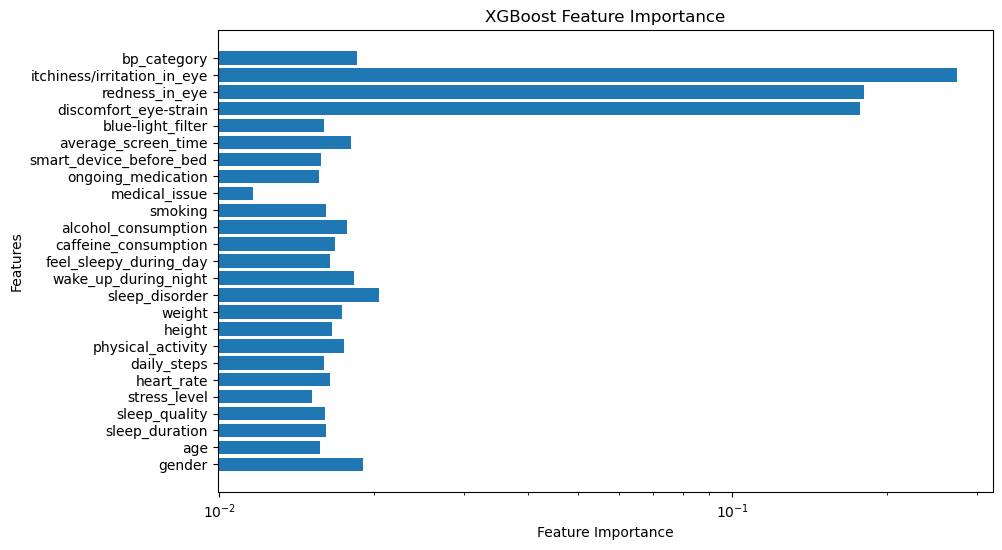

In [60]:
# Feature Importance
feature_names = X.columns.tolist()
importance = best_xgb.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.xscale('log')
plt.show()

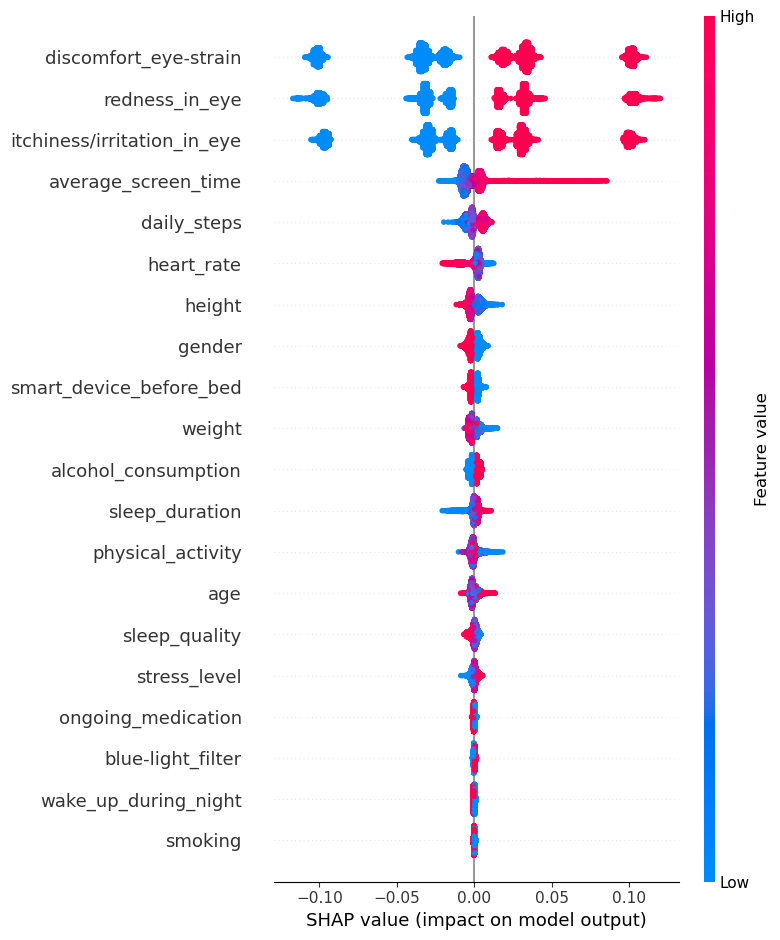

In [61]:
# SHAP values for feature selection
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feature_names)


In [62]:
importance

array([0.01906609, 0.01569563, 0.01618262, 0.01610698, 0.01514371,
       0.01646606, 0.01603785, 0.0174839 , 0.01656438, 0.01732461,
       0.02052919, 0.01828746, 0.01643082, 0.01681754, 0.01777833,
       0.01617828, 0.01162568, 0.015664  , 0.01576409, 0.01807602,
       0.01602157, 0.17736617, 0.1805723 , 0.27427378, 0.01854292],
      dtype=float32)

0.27427378


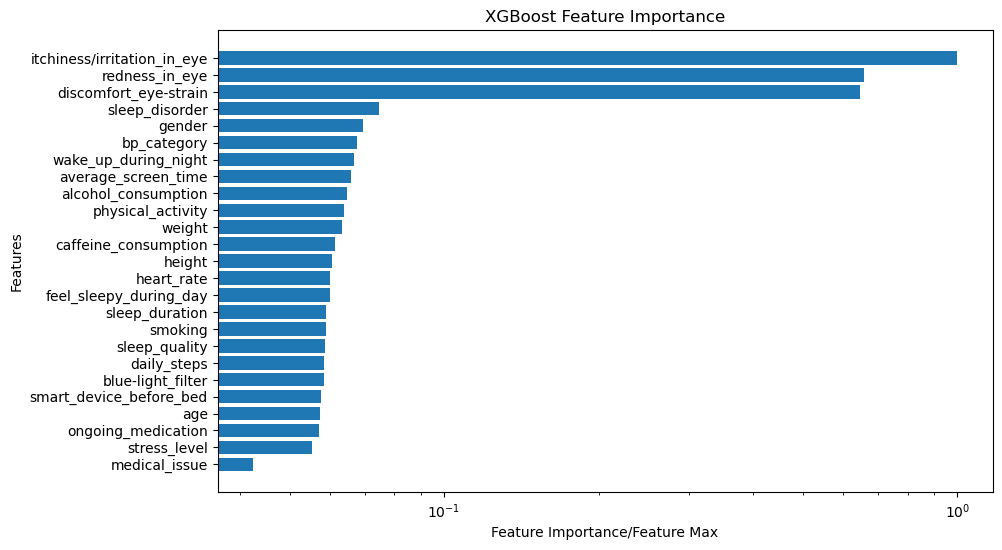

In [77]:
f_pairs = list(zip(importance, feature_names))
f_pairs.sort()
importance_sort, feature_names_sort = zip(*f_pairs)
max_imp = importance.max()
print(max_imp)
plt.figure(figsize=(10,6))
plt.barh(list(feature_names_sort), list(importance_sort)/max_imp)
plt.xlabel("Feature Importance/Feature Max")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.xscale('log')
plt.show()


In [78]:
f_pairs


[(np.float32(0.011625682), 'medical_issue'),
 (np.float32(0.015143713), 'stress_level'),
 (np.float32(0.015663996), 'ongoing_medication'),
 (np.float32(0.015695633), 'age'),
 (np.float32(0.015764086), 'smart_device_before_bed'),
 (np.float32(0.016021566), 'blue-light_filter'),
 (np.float32(0.016037852), 'daily_steps'),
 (np.float32(0.016106976), 'sleep_quality'),
 (np.float32(0.016178282), 'smoking'),
 (np.float32(0.016182618), 'sleep_duration'),
 (np.float32(0.016430816), 'feel_sleepy_during_day'),
 (np.float32(0.016466057), 'heart_rate'),
 (np.float32(0.016564377), 'height'),
 (np.float32(0.016817542), 'caffeine_consumption'),
 (np.float32(0.01732461), 'weight'),
 (np.float32(0.017483903), 'physical_activity'),
 (np.float32(0.017778326), 'alcohol_consumption'),
 (np.float32(0.018076016), 'average_screen_time'),
 (np.float32(0.018287461), 'wake_up_during_night'),
 (np.float32(0.018542917), 'bp_category'),
 (np.float32(0.019066086), 'gender'),
 (np.float32(0.02052919), 'sleep_disorder'

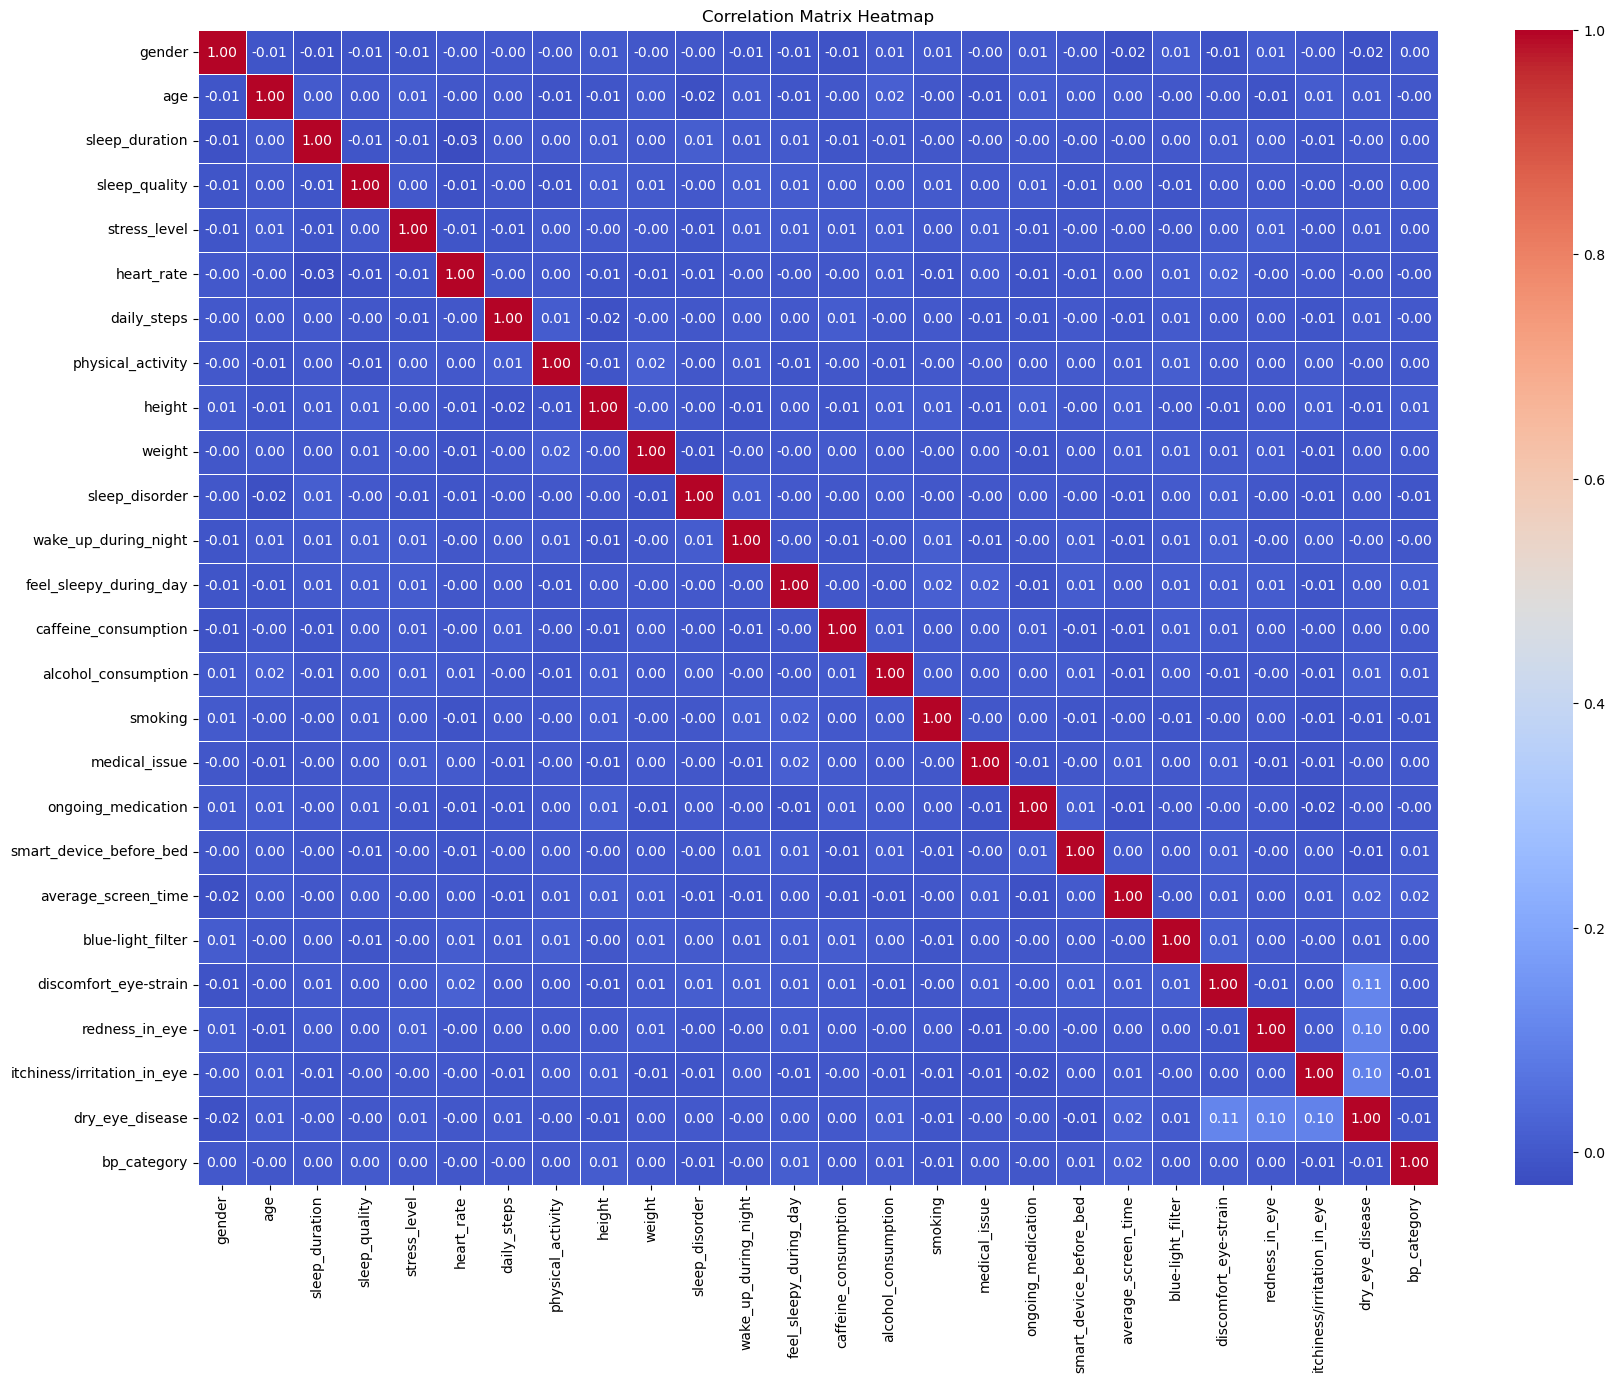

In [79]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
from matplotlib.colors import SymLogNorm
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()